# Filtering the Congressional Record and Hansard


This notebook contains the code needed to filter the Congressional Record and Hansard datasets. The code creates two pairs of corpuses with cleaned and stemmed text. The first pair contains only speeches from the Congressional Record and Hansard that discuss issues relating to climate change. The second contains all speeches made between 1997 and 2015 for each corpus.


## Setup


In [26]:
import ssl
import re
import nltk
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay

CONGRESSIONAL_RECORD_PATH = '../../congressional-record/dist/'
HANSARD_PATH = '../../hansard-in-full/'
CLIMATE_DICTIONARY_PATH = '../dictionaries/dist/'
CONGRESSIONAL_RECORD_PROCEDURAL_STEMS_PATH = '../dictionaries/dist/'
HANSARD_PROCEDURAL_STEMS_PATH = '../dictionaries/dist/'

DATA_PATH = 'data/'
DIST_PATH = 'dist/'

YEAR_RANGE = (1997, 2015)

plt.style.use('ggplot')

# Ignore SSL certificate errors
ssl._create_default_https_context = ssl._create_unverified_context

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/felixwallis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/felixwallis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Preprocessing


### Preprocessing functions for the Congressional Record and Hansard


In [63]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()


def tokenize_and_stem(text):
    # Text should almost always be a string, but we check just in case
    if not isinstance(text, str):
        text = str(text)
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation, numbers, and symbols
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stop words
    filtered_tokens = [word for word in tokens if word not in stop_words]
    # Stem the tokens
    stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]
    # Rejoin the stemmed tokens
    joined_stems = ' '.join(stemmed_tokens)
    return joined_stems


def corpus_preprocessing(corpus: pd.DataFrame,
                         text_column_name: str,
                         year_range: tuple,
                         min_df: int = 10,
                         year_column_name: str = 'year'):
    corpus = corpus.copy()
    # Remove corpus content from outside the year range
    corpus = corpus[corpus[year_column_name].between(
        year_range[0], year_range[1])]
    # Clean, tokenize, and stem the corpus
    tqdm.pandas(desc="Processing Text")
    corpus['cleaned_stems'] = corpus[text_column_name].progress_apply(
        tokenize_and_stem)
    # Remove any documents with fewer than 10 stems
    corpus['stem_count'] = corpus['cleaned_stems'].apply(
        lambda x: len(x.split()))
    corpus = corpus[corpus['stem_count'] >= 50]

    # Remove stems that occur in less than min_df documents
    vectorizer = CountVectorizer(min_df=min_df)
    vectorizer.fit_transform(corpus['cleaned_stems'])
    allowed_words = set(vectorizer.get_feature_names_out())
    corpus['cleaned_stems'] = corpus['cleaned_stems'].apply(
        lambda x: ' '.join([word for word in x.split() if word in allowed_words]))

    return corpus

### Congressional Record preprocessing


**Loading the Congressional Record**


In [2]:
congressional_record = pd.read_csv(
    CONGRESSIONAL_RECORD_PATH + 'congressional_record.csv')

**Preprocessing the Congressional Record**


In [65]:
congressional_record['date'] = pd.to_datetime(
    congressional_record['date'], format='%Y%m%d')
congressional_record['year'] = congressional_record['date'].dt.year

# Remove any speeches with missing speaker_id
congressional_record = congressional_record.dropna(subset=['speaker_id'])

congressional_record = corpus_preprocessing(
    congressional_record, 'speech', YEAR_RANGE)

congressional_record.to_csv(
    DATA_PATH + 'congressional_record.csv', index=False)

Processing Text: 100%|██████████| 1080262/1080262 [25:44<00:00, 699.29it/s] 


### Hansard preprocessing


**Loading Hansard**


In [66]:
hansard = pd.read_csv(HANSARD_PATH + 'hansard_with_mp_details.csv')

**Preprocessing Hansard**


In [67]:
hansard['speech_date'] = pd.to_datetime(hansard['speech_date'])
hansard['year'] = hansard['speech_date'].dt.year

# Remove any speeches with missing memberships
hansard = hansard.dropna(subset=['memberships'])

hansard = corpus_preprocessing(hansard, 'text', YEAR_RANGE)

hansard.to_csv(DATA_PATH + 'hansard.csv', index=False)

Processing Text: 100%|██████████| 1110136/1110136 [09:30<00:00, 1945.29it/s]


## Filtering


### Filtering functions for the Congressional Record and Hansard


In [35]:
hansard = pd.read_csv(DATA_PATH + 'hansard.csv')
congressional_record = pd.read_csv(DATA_PATH + 'congressional_record.csv')

congressional_record_procedural_stems = pd.read_csv(
    CONGRESSIONAL_RECORD_PROCEDURAL_STEMS_PATH + 'shortened_congressional_record_procedural_stems.csv')
congressional_record_procedural_stems = set(
    congressional_record_procedural_stems['stem'].tolist())

hansard_procedural_stems = pd.read_csv(
    HANSARD_PROCEDURAL_STEMS_PATH + 'expanded_hansard_procedural_stems.csv')
hansard_procedural_stems = set(hansard_procedural_stems['stem'].tolist())

climate_stems = pd.read_csv(
    CLIMATE_DICTIONARY_PATH + 'shortened_climate_stems.csv')
climate_stems = set(climate_stems['stem'].tolist())


def term_proportion(doc, terms):
    doc_tokens = set(doc.split())
    term_count = sum(
        term in doc_tokens for term in terms)
    total_terms = len(doc_tokens)

    if total_terms == 0:
        return 0
    return term_count / total_terms


def procedural_stems_filter(corpus_df, procedural_stems, threshold: float = 0.5):
    corpus_df = corpus_df.copy()
    # Remove documents that contain more than than the threshold of procedural stems
    corpus_df['procedural_proportion'] = corpus_df['cleaned_stems'].apply(
        lambda doc: term_proportion(doc, procedural_stems))
    corpus_df = corpus_df[corpus_df['procedural_proportion'] < threshold]
    # Remove all procedural stems from the remaining documents
    corpus_df['cleaned_stems'] = corpus_df['cleaned_stems'].apply(
        lambda doc: ' '.join([word for word in doc.split() if word not in procedural_stems]))
    return corpus_df


def topic_stems_filter(corpus_df, topic_stems, threshold: float = 0.2):
    corpus_df = corpus_df.copy()
    # Remove any documents that contain fewer than the threshold proportion of topic stems
    corpus_df['topic_proportion'] = corpus_df['cleaned_stems'].apply(
        lambda doc: term_proportion(doc, topic_stems))
    corpus_df = corpus_df[corpus_df['topic_proportion'] > threshold]
    return corpus_df

### Removing procedural documents and stems from the Congressional Record and Hansard


**Removing procedural documents and stems from the Congressional Record**


In [69]:
non_procedural_congressional_record = procedural_stems_filter(
    congressional_record, congressional_record_procedural_stems, 0.5)

non_procedural_congressional_record.to_csv(
    DATA_PATH + 'non_procedural_congressional_record.csv', index=False)

**Removing procedural documents and stems from Hansard**


In [70]:
non_procedural_hansard = procedural_stems_filter(
    hansard, hansard_procedural_stems, 0.5)

non_procedural_hansard.to_csv(
    DATA_PATH + 'non_procedural_hansard.csv', index=False)

### Separating climate change documents from the Congressional Record and Hansard


**Separating climate change documents from the Congressional Record**


In [4]:
non_procedural_congressional_record = pd.read_csv(
    DATA_PATH + 'non_procedural_congressional_record.csv')

climate_congressional_record = topic_stems_filter(
    non_procedural_congressional_record, climate_stems, 0.02)
climate_congressional_record = climate_congressional_record.sort_values(
    'topic_proportion', ascending=False)

climate_indices = climate_congressional_record.index
non_climate_congressional_record = non_procedural_congressional_record.drop(
    climate_indices)

climate_congressional_record.to_csv(
    DATA_PATH + 'climate_congressional_record.csv', index=False)
non_climate_congressional_record.to_csv(
    DATA_PATH + 'non_climate_congressional_record.csv', index=False)

**Separating climate change documents from Hansard**


In [5]:
non_procedural_hansard = pd.read_csv(DATA_PATH + 'non_procedural_hansard.csv')

climate_hansard = topic_stems_filter(
    non_procedural_hansard, climate_stems, 0.02)
climate_hansard = climate_hansard.sort_values(
    'topic_proportion', ascending=False)

climate_indices = climate_hansard.index
non_climate_hansard = non_procedural_hansard.drop(climate_indices)

climate_hansard.to_csv(DATA_PATH + 'climate_hansard.csv', index=False)
non_climate_hansard.to_csv(DATA_PATH + 'non_climate_hansard.csv', index=False)

## Filtering validation


Since the rest of the analysis is heavily dependent on what texts are filtered from Hansard and the Congressional Record, we need to validate how well the filtering process worked. This validation process involves the following steps:

- Creating a labelled dataset of climate change speeches from Hansard and the Congressional Record.
- Testing the performance of the climate change dictionary on the labelled dataset using the filtering rules applied above.
- Optimising the filtering rules based on the climate change dictionary's performance.


### Creating a labelled dataset of climate change speeches from Hansard and the Congressional Record


To create a labelled dataset, we first take a random sample of speecehs from Hansard made in 2008. Selecitng speeches from 2008 means that our sample is not representative of the entire Hansard corpus. However, given that 2008 was the year the UK Climate Change Act passed, it ensures we find some positive examples of climate change speeches. After making this random selection, we do the same for the Congressional Record, instead sampling speeches from 2009. 2009 was the year that the US Clean Energy and Security Act passed in the House of Representatives, but stalled in the Senate. Hence, we should find some positive examples of climate change speeches in this sample as well.


**Loading the Congressional Record and Hansard**


In [39]:
non_procedural_hansard = pd.read_csv(DATA_PATH + 'non_procedural_hansard.csv')
non_procedural_congressional_record = pd.read_csv(
    DATA_PATH + 'non_procedural_congressional_record.csv')

**Randomly sampling 500 speeches from the Congressional Record in 2009**


In [40]:
random.seed(42)
congressional_record_2009 = non_procedural_congressional_record[
    non_procedural_congressional_record['year'] == 2009]
congressional_record_2009_sample = congressional_record_2009.sample(500)

congressional_record_2009_sample.to_csv(
    DATA_PATH + 'congressional_record_sample.csv', index=False)

**Randomly sampling 500 speeches from Hansard in 2008**


In [41]:
random.seed(42)
hansard_2008 = non_procedural_hansard[non_procedural_hansard['year'] == 2008]
hansard_2008_sample = hansard_2008.sample(500)

hansard_2008_sample.to_csv(
    DATA_PATH + 'hansard_sample.csv', index=False)

At this point, human coding is used to label the speeches in each sample as either climate change related or not. These annotations are saved as [classified_hansard_sample.csv](./data/classified_hansard_sample.csv) and [classified_congressional_record_sample.csv](./data/classified_congressional_record_sample.csv).


### Testing dictionary performance


We can now test the performance of the climate change dictionary on the labelled datasets at different thresholds.


**Congressional Record**


/Users/felixwallis/Desktop/UCL Politics and International Relations Course/Dissertation/pir-dissertation/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/felixwallis/Desktop/UCL Politics and International Relations Course/Dissertation/pir-dissertation/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/felixwallis/Desktop/UCL Politics and International Relations Course/Dissertation/pir-dissertation/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: U

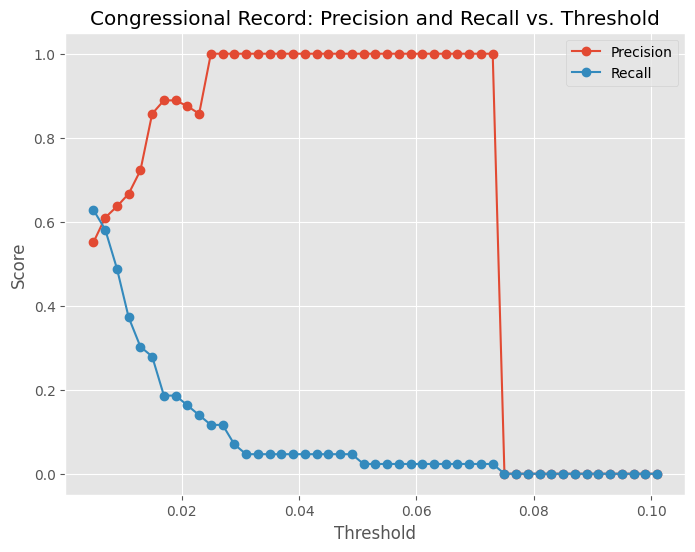

In [72]:
classified_congressional_record_sample = pd.read_csv(
    DATA_PATH + 'classified_congressional_record_sample.csv')
labels = classified_congressional_record_sample['climate_change_content']

start_threshold = 0.005
end_threshold = 0.1
step = 0.002

thresholds = np.arange(start_threshold, end_threshold + step, step)
precision_scores = []
recall_scores = []

for threshold in thresholds:
    predicted_climate_change_content = topic_stems_filter(
        classified_congressional_record_sample, climate_stems, threshold)
    classified_congressional_record_sample['predicted_climate_change_content'] = classified_congressional_record_sample.index.isin(
        predicted_climate_change_content.index)
    predicted_labels = classified_congressional_record_sample['predicted_climate_change_content']

    precision = precision_score(
        labels, predicted_labels, pos_label=True)
    recall = recall_score(labels, predicted_labels, pos_label=True)
    precision_scores.append(precision)
    recall_scores.append(recall)

# Plot precision and recall scores against thresholds
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision_scores, marker='o', label='Precision')
plt.plot(thresholds, recall_scores, marker='o', label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Congressional Record: Precision and Recall vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()

**Hansard**


/Users/felixwallis/Desktop/UCL Politics and International Relations Course/Dissertation/pir-dissertation/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/felixwallis/Desktop/UCL Politics and International Relations Course/Dissertation/pir-dissertation/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/felixwallis/Desktop/UCL Politics and International Relations Course/Dissertation/pir-dissertation/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: U

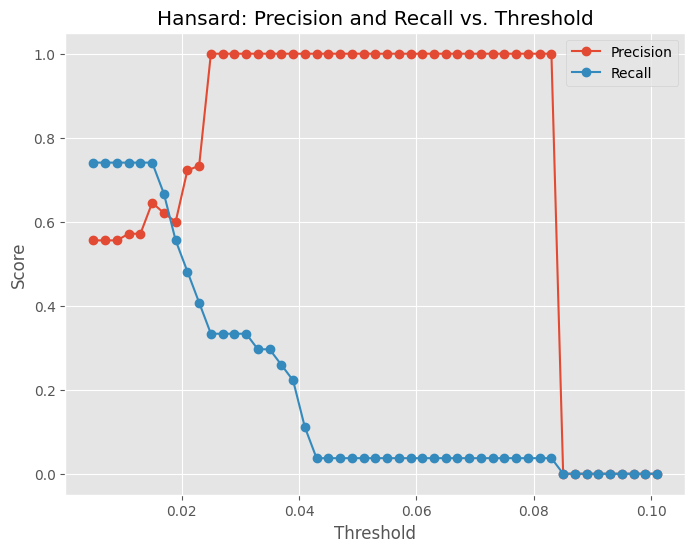

In [73]:
classified_hansard_sample = pd.read_csv(
    DATA_PATH + 'classified_hansard_sample.csv')
labels = classified_hansard_sample['climate_change_content']

start_threshold = 0.005
end_threshold = 0.1
step = 0.002

thresholds = np.arange(start_threshold, end_threshold + step, step)
precision_scores = []
recall_scores = []

for threshold in thresholds:
    predicted_climate_change_content = topic_stems_filter(
        classified_hansard_sample, climate_stems, threshold)
    classified_hansard_sample['predicted_climate_change_content'] = classified_hansard_sample.index.isin(
        predicted_climate_change_content.index)
    predicted_labels = classified_hansard_sample['predicted_climate_change_content']

    precision = precision_score(
        labels, predicted_labels, pos_label=True)
    recall = recall_score(labels, predicted_labels, pos_label=True)
    precision_scores.append(precision)
    recall_scores.append(recall)

# Plot precision and recall scores against thresholds
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision_scores, marker='o', label='Precision')
plt.plot(thresholds, recall_scores, marker='o', label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Hansard: Precision and Recall vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()

### Testing party balance


We also want to test how the filtering process affects the balance of parties in the filtered datasets. The threshold should not have a statistically significant effect on this balance. Otherwise, the following results are likely being driven by the filtering process rather than the content of the speeches.


**Congressional Record**


In [47]:
non_procedural_congressional_record = pd.read_csv(
    DATA_PATH + 'non_procedural_congressional_record.csv')

Processing thresholds: 100%|██████████| 49/49 [05:43<00:00,  7.01s/it]


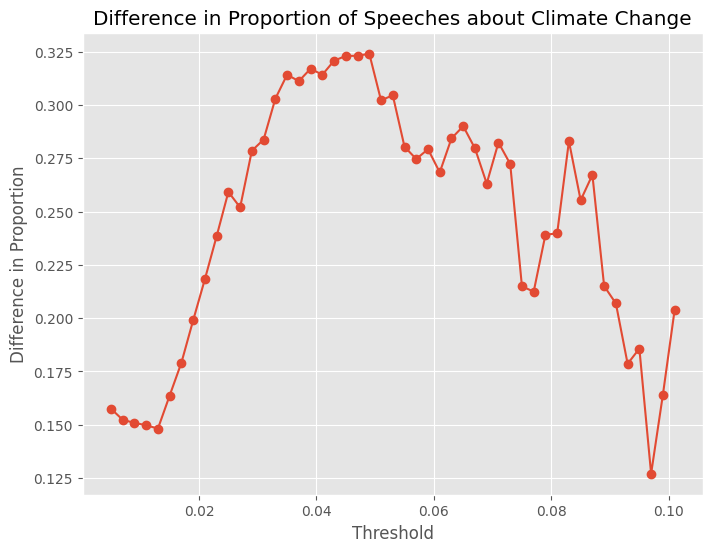

In [74]:
start_threshold = 0.005
end_threshold = 0.1
step = 0.002
thresholds = np.arange(start_threshold, end_threshold + step, step)

diff_prop_climate_speeches_list = []

for threshold in tqdm(thresholds, desc="Processing thresholds"):
    climate_congressional_record = topic_stems_filter(
        non_procedural_congressional_record, climate_stems, threshold)

    republican_climate_speeches = climate_congressional_record[
        climate_congressional_record['party'] == 'R']
    democratic_climate_speeches = climate_congressional_record[
        climate_congressional_record['party'] == 'D']

    prop_republican_climate_speeches = len(
        republican_climate_speeches) / len(climate_congressional_record)
    prop_democratic_climate_speeches = len(
        democratic_climate_speeches) / len(climate_congressional_record)

    diff_prop_climate_speeches = prop_democratic_climate_speeches - \
        prop_republican_climate_speeches
    diff_prop_climate_speeches_list.append(diff_prop_climate_speeches)

# Plot the difference in proportion of speeches about climate change against thresholds
plt.figure(figsize=(8, 6))
plt.plot(thresholds, diff_prop_climate_speeches_list, marker='o')
plt.xlabel('Threshold')
plt.ylabel('Difference in Proportion')
plt.title(
    'Congressional Record: Difference in Proportion of Speeches about Climate Change')
plt.grid(True)
plt.show()

**Hansard**


In [62]:
non_procedural_hansard = pd.read_csv(DATA_PATH + 'non_procedural_hansard.csv')

Processing thresholds: 100%|██████████| 49/49 [01:20<00:00,  1.64s/it]


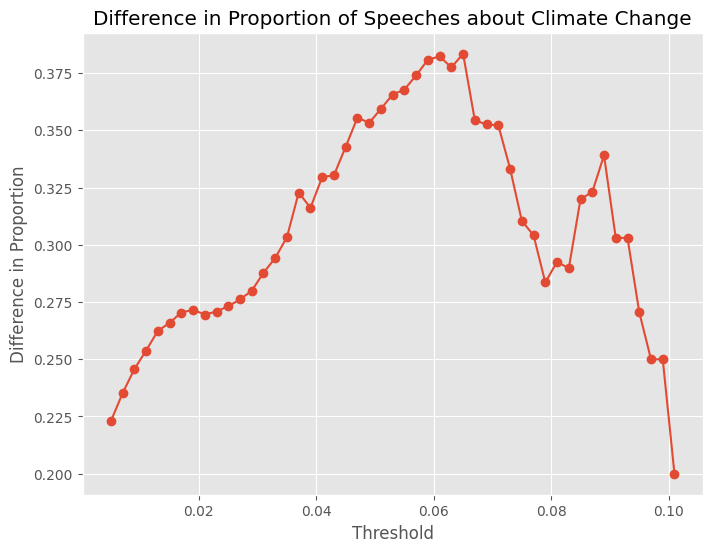

In [71]:
start_threshold = 0.005
end_threshold = 0.1
step = 0.002

thresholds = np.arange(start_threshold, end_threshold + step, step)
diff_prop_climate_speeches_list = []

for threshold in tqdm(thresholds, desc="Processing thresholds"):
    climate_hansard = topic_stems_filter(
        non_procedural_hansard, climate_stems, threshold)

    conservative_climate_speeches = climate_hansard[
        climate_hansard['speech_party'] == 'Conservative']
    labour_climate_speeches = climate_hansard[
        climate_hansard['speech_party'] == 'Labour']

    prop_conservative_climate_speeches = len(
        conservative_climate_speeches) / len(climate_hansard)
    prop_labour_climate_speeches = len(
        labour_climate_speeches) / len(climate_hansard)

    diff_prop_climate_speeches = prop_labour_climate_speeches - \
        prop_conservative_climate_speeches
    diff_prop_climate_speeches_list.append(diff_prop_climate_speeches)

# Plot the difference in proportion of speeches about climate change against thresholds
plt.figure(figsize=(8, 6))
plt.plot(thresholds, diff_prop_climate_speeches_list, marker='o')
plt.xlabel('Threshold')
plt.ylabel('Difference in Proportion')
plt.title('Hansard: Difference in Proportion of Speeches about Climate Change')
plt.grid(True)
plt.show()